# Neural Network from Scratch with Numpy

## Imports

In [1]:
%matplotlib inline

import gzip, hashlib, os, requests

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Load Data

In [2]:
# Modified from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb written by George Hotz

def fetch_data(url):
    fp = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            data = f.read()
    else:
        with open(fp, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

x_train = fetch_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

x_test = fetch_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

val_idx = np.random.choice(np.arange(x_train.shape[0]), size=10000, replace=False)
mask = np.zeros(x_train.shape[0], dtype=bool)
mask[val_idx] = True

x_val = x_train[mask]
y_val = y_train[mask]

x_train = x_train[~mask]
y_train = y_train[~mask]

print(f'train shape: {x_train.shape}')
print(f'val shape: {x_val.shape}')
print(f'test shape: {x_test.shape}')

train shape: (50000, 28, 28)
val shape: (10000, 28, 28)
test shape: (10000, 28, 28)


In [3]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

Label: 5


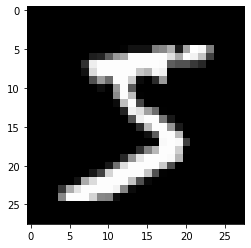

In [4]:
print(f'Label: {y_train[0]}')
img = plt.imshow(x_train[0], cmap='gray', vmin=0, vmax=1)

## Initialize Weights and Bias

In [5]:
def init_random(l1, l2):
    weights = np.random.rand(l1, l2) - 0.5
    biases = np.random.rand(l2) - 0.5
    
    return weights, biases

## Activation Functions

In [6]:
def sigmoid(x, derivative=False):
    if derivative:
        f_x = np.exp(-x) / np.square(np.exp(-x) + 1)
    else:
        f_x = 1 / (np.exp(-x) + 1)

    return f_x

## Defining the Network

In [7]:
class NumpyNN:
    def __init__(self, lr, epsilon, init_fn, act_fn):
        self.w1, self.b1 = init_fn(28 * 28, 128)
        self.w2, self.b2 = init_fn(128, 64)
        self.w3, self.b3 = init_fn(64, 10)
        self.lr = lr
        self.epsilon = epsilon
        self.act_fn = act_fn

    def one_hot(self, y):
        y_hot = np.zeros((y.size, 10))
        y_hot[np.arange(y.size), y] = 1
        
        return y_hot

    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        f_x =  e_x / np.sum(e_x, axis=1, keepdims=True)

        return f_x

    def accuracy(self, y):
        y_hat = np.argmax(self.a3, axis=1)
        accuracy = np.sum(y_hat == y) / y.size

        return accuracy

    def loss(self, y):
        y_hot = self.one_hot(y)
        losses = -np.sum(y_hot * np.log(self.a3 + self.epsilon), axis=1)
        loss = np.mean(losses)
        
        return loss

    def forward(self, x):
        x = np.reshape(x, (-1, 28 * 28))

        self.z1 = x @ self.w1 + self.b1
        self.a1 = self.act_fn(self.z1)

        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = self.act_fn(self.z2)

        z3 = self.a2 @ self.w3 + self.b3
        self.a3 = self.softmax(z3)

        return self.a3

    def backward(self, x, y):
        x = np.reshape(x, (-1, 28 * 28))
        y_hot = self.one_hot(y)
        n = y_hot.shape[0]

        dz3 = self.a3 - y_hot
        self.dw3 = (self.a2.T @ dz3) / n
        self.db3 = np.sum(dz3, axis=0) / n

        dz2 = (dz3 @ self.w3.T) * self.act_fn(self.z2, derivative=True)
        self.dw2 = (dz2.T @ self.a1).T / n
        self.db2 = np.sum(dz2, axis=0) / n

        dz1 = (dz2 @ self.w2.T) * self.act_fn(self.z1, derivative=True)
        self.dw1 = (dz1.T @ x).T / n
        self.db1 = np.sum(dz1, axis=0) / n

    def update_parameters(self):
        self.w1 -= self.lr * self.dw1
        self.b1 -= self.lr * self.db1
        self.w2 -= self.lr * self.dw2
        self.b2 -= self.lr * self.db2
        self.w3 -= self.lr * self.dw3
        self.b3 -= self.lr * self.db3

## Hyperparameters

In [8]:
lr = 0.75
epochs = 250
epsilon = 1e-7

## Train Network

In [9]:
model = NumpyNN(lr, epsilon, init_random, sigmoid)
accuracies = []
losses = []

for epoch in range(epochs):
    output = model.forward(x_train)
    model.backward(x_train, y_train)
    model.update_parameters()

    accuracy = model.accuracy(y_train)
    loss = model.loss(y_train)
    accuracies.append(accuracy)
    losses.append(loss)

    if (epoch + 1) % 10 == 0:
        print(f'[{epoch + 1}/{epochs}] Accuracy: {np.round(accuracy * 100, 2)}% Loss: {np.round(loss, 4)}')

[10/250] Accuracy: 47.14% Loss: 1.8614
[20/250] Accuracy: 65.4% Loss: 1.426
[30/250] Accuracy: 72.97% Loss: 1.1243
[40/250] Accuracy: 77.44% Loss: 0.9226
[50/250] Accuracy: 80.26% Loss: 0.7885
[60/250] Accuracy: 82.26% Loss: 0.6968
[70/250] Accuracy: 83.68% Loss: 0.631
[80/250] Accuracy: 84.74% Loss: 0.5816
[90/250] Accuracy: 85.6% Loss: 0.5431
[100/250] Accuracy: 86.21% Loss: 0.5122
[110/250] Accuracy: 86.77% Loss: 0.4868
[120/250] Accuracy: 87.26% Loss: 0.4656
[130/250] Accuracy: 87.69% Loss: 0.4474
[140/250] Accuracy: 88.03% Loss: 0.4317
[150/250] Accuracy: 88.34% Loss: 0.418
[160/250] Accuracy: 88.63% Loss: 0.4059
[170/250] Accuracy: 88.86% Loss: 0.395
[180/250] Accuracy: 89.12% Loss: 0.3853
[190/250] Accuracy: 89.33% Loss: 0.3764
[200/250] Accuracy: 89.56% Loss: 0.3683
[210/250] Accuracy: 89.72% Loss: 0.3609
[220/250] Accuracy: 89.91% Loss: 0.354
[230/250] Accuracy: 90.08% Loss: 0.3476
[240/250] Accuracy: 90.22% Loss: 0.3416
[250/250] Accuracy: 90.39% Loss: 0.336


## Plot Accuracy and Loss

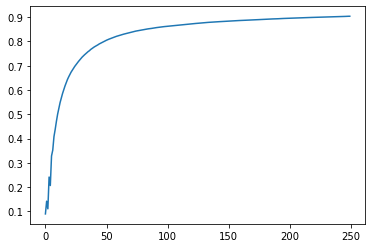

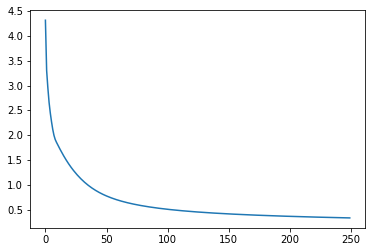

In [12]:
tmp = plt.plot(accuracies)
plt.show()
tmp = plt.plot(losses)
plt.show()

## Test Accuracy

In [14]:
output = model.forward(x_test)
accuracy = model.accuracy(y_test)
print(f'Accuracy: {np.round(accuracy * 100, 2)}')

Accuracy: 91.06
